<a href="https://colab.research.google.com/github/rochadelon/AtlanticoAvanti/blob/main/Etapa_4_treinado_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EXPLORAÇÃO GERAL DE DADOS - APROVEITAR CÓDIGOS DA 1º ETAPA DE FORMA ORGANIZADA - GABY FEITO

* Importação das bibliotecas

In [ ]:
import os
import pandas as pd
import seaborn as sns
import pandas
import cv2
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import tensorflow as tf
import tensorflow as tf
import time
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from IPython.display import display, Markdown as md
from collections import defaultdict
from google.colab import drive
from tensorflow.keras import utils,Sequential,layers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

!pip install google-colab # usado para ler o dataset diretamente de uma pasta pública no Drive

## Caminho do dataset
    

* Cada membro deverá entrar no link [dataset no drive](https://drive.google.com/drive/u/0/folders/1VDOQge9ldgKK6UjNlujcgVd0oAsX2xBV) e clicar em **"Adicionar atalho ao Drive"**

In [ ]:
# Vai montar um Google Drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/dataset_retina'
dataset_path = Path(path)
# Definição dos caminhos das pastas de treino e teste dentro do dataset
pasta_treinamento  = os.path.join(path, "Data", "train")  # Caminho para as imagens de treino
pasta_teste  = os.path.join(path, "Data", "test")  # Caminho para as imagens de teste

Mounted at /content/drive


## EXPLORAÇÃO INICIAL DO DATASET

*   Função para coletar infos iniciais (quantas imagens, tamanho, pixels, nome da pasta, etc)





In [ ]:
imagens_info = []
for pasta_raiz, subpastas, arquivos in os.walk(path): #percorrendo diretorios e subdiretorios dentro do caminho em path
  for arquivo in arquivos: #percorre a lista de arquivos dentro da pasta atual
    if arquivo.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')): #se os arquivos tiverem essas extensões
      caminho_completo = os.path.join(pasta_raiz, arquivo) # cria o caminho absoluto do arquivo, unindo a pasta onde ele está com seu nome.
      categoria = os.path.basename(pasta_raiz) #retorna apenas o nome da última pasta no caminho. (ex: "C:/Users/Hanna/Imagens/Dataset/Gatos")
      #ele vai me retornar GATOS
      with Image.open(caminho_completo) as img:
                largura, altura = img.size  # Dimensões
                num_pixels = largura * altura  # Total de pixels
                modo = img.mode  # Modo da imagem (RGB, Grayscale etc.)
      imagens_info.append({
          'arquivo' : arquivo, #nome do arquivo da imagem
          'caminho' : caminho_completo, #caminho do arquivo
          'categoria' : categoria, #nome da pasta onde está a imagem
          'largura': largura, #adicionei para printar as dimensões depois
          'altura': altura, #adicionei para printar as dimensões depois
          'num_pixels': num_pixels, #adicionei para printar as dimensões depois
          'modo' : modo #modo L indica que a imagem tem 8bits por pixel, 256 níves de cinza (variando de 0 preto a 255 branco)
          }) #dicionario criado com tres infos: nomedoarquivo / caminho do arquivo / e qual categoria da imagem (mask)

df_imagens = pd.DataFrame(imagens_info) #converte a lista de dicionários em um dataframe do pandas

print(f"Total de imagens: {len(df_imagens)}") #total de imagens = 200

Total de imagens: 200



*   Conferir os formatos das imagens

In [ ]:
# Verificação se todas as imagens estão no mesmo formato
# Lista para armazenar os formatos das imagens
formatos_imagens  = set()

# Percorrer todos os arquivos do diretório

for file in dataset_path.rglob("*"):
    if file.is_file():
        try:
            with Image.open(file) as img:
                formatos_imagens .add(img.format)
        except Exception as e:
            print(f"Erro ao processar {file}: {e}")

# Exibe os formatos encontrados

print("Formatos de imagem encontrados:", formatos_imagens )

# Verifica se todas as imagens têm o mesmo formato

if len(formatos_imagens ) == 1:
    print(f"Todas as imagens estão no formato {list(formatos_imagens )[0]}.")
else:
    print("As imagens possuem formatos diferentes.")

Formatos de imagem encontrados: {'PNG'}
Todas as imagens estão no formato PNG.



*   Conferindo se todas as imagens tem o mesmo tamanho


In [ ]:
if df_imagens[['largura', 'altura']].nunique().sum() == 2: #nunique() conta quantos valores diferentes existem nas colunas largura e altura
    print("Todas as imagens têm o mesmo tamanho.")
else:
    print("As imagens têm tamanhos diferentes.")

Todas as imagens têm o mesmo tamanho.


*   Conferir o modelo de cor das imagens


In [ ]:
# Agrupa as imagens por categoria (pasta) e lista os modos de cor encontrados em cada uma
modos_por_categoria = df_imagens.groupby('categoria')['modo'].unique()

# Exibe os modos de cor encontrados para cada categoria
for categoria, modos in modos_por_categoria.items():
    print(f"Na pasta '{categoria}', encontramos os modos de cor: {modos}")

# Cria um dicionário para armazenar inconsistências
# Se uma categoria tiver mais de um modo de cor, será considerada inconsistente
inconsistencias = {cat: modos for cat, modos in modos_por_categoria.items() if len(modos) > 1}

# Verifica se foram encontradas inconsistências
if inconsistencias:
    print("\nAtenção! Algumas categorias possuem imagens com diferentes modos de cor:")
    for cat, modos in inconsistencias.items():
        print(f"- {cat}: {modos}")  # Exibe a categoria e os modos de cor encontrados nela
else:
    print("\nTodas as categorias possuem um único modo de cor. Nenhuma inconsistência encontrada.")


Na pasta 'image', encontramos os modos de cor: ['RGB']
Na pasta 'mask', encontramos os modos de cor: ['L']

Todas as categorias possuem um único modo de cor. Nenhuma inconsistência encontrada.


*  Tabela com infos gerais das imagens (categoria, largura, altura)

In [ ]:
from IPython.display import display, Markdown as md

def sumario_coluna(df):
    """
    Gera um resumo das colunas de um DataFrame.

    Para cada coluna, o resumo contém:
    - Nome da coluna
    - Tipo de dado
    - Quantidade de valores distintos
    - (Opcional) Contagem de valores, caso tenha 10 ou menos valores distintos
    """
    dados_resumo = []

    for nome_coluna in df.columns:
        tipo_coluna = df[nome_coluna].dtype
        valores_distintos = df[nome_coluna].nunique()

        contagem_distintos = None
        if valores_distintos <= 10:
            contagem_distintos = df[nome_coluna].value_counts().to_dict()

        dados_resumo.append([
            nome_coluna,
            str(tipo_coluna),
            valores_distintos,
            contagem_distintos
        ])

    # Markdown para exibição
    saida_markdown = "## 📊 Sumário das Colunas\n\n"
    saida_markdown += "| Coluna | Tipo de Dado | Valores Distintos | Distribuição dos Valores |\n"
    saida_markdown += "|--------|---------------|-------------------|--------------------------|\n"

    for col in dados_resumo:
        distribuicao = col[3] if col[3] is not None else "N/A"
        saida_markdown += f"| `{col[0]}` | `{col[1]}` | {col[2]} | {distribuicao} |\n"

    display(md(saida_markdown))

# Exemplo de uso
sumario_coluna(df_imagens)

## 📊 Sumário das Colunas

| Coluna | Tipo de Dado | Valores Distintos | Distribuição dos Valores |
|--------|---------------|-------------------|--------------------------|
| `arquivo` | `object` | 80 | N/A |
| `caminho` | `object` | 200 | N/A |
| `categoria` | `object` | 2 | {'mask': 100, 'image': 100} |
| `largura` | `int64` | 1 | {512: 200} |
| `altura` | `int64` | 1 | {512: 200} |
| `num_pixels` | `int64` | 1 | {262144: 200} |
| `modo` | `object` | 2 | {'L': 100, 'RGB': 100} |


* Visualizando algumas imagens do dataset

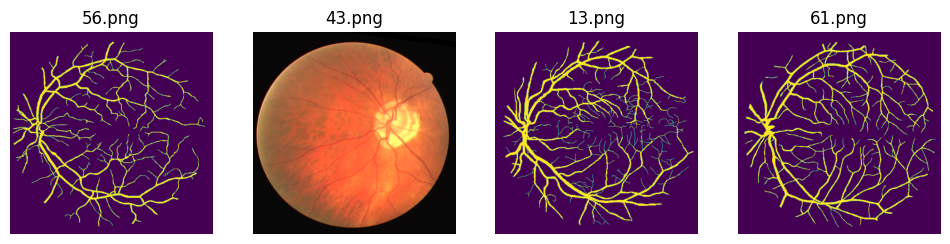

In [ ]:
amostras = df_imagens.sample(4)  # visualizando 4 imagens do dataframe

fig, axes = plt.subplots(1, 4, figsize=(12, 6)) #plotando as imagens
for ax, (_, row) in zip(axes, amostras.iterrows()):
    img = Image.open(row["caminho"])  # Abre a imagem
    ax.imshow(img)
    ax.set_title(row["arquivo"])
    ax.axis("off")  # Remove os eixos

plt.show()

Informações complementares, tamanho, pixel e dimensões da figura

In [ ]:
print(df_imagens[['largura', 'altura', 'num_pixels']].describe()) #não há variação nas imagens

       largura  altura  num_pixels
count    200.0   200.0       200.0
mean     512.0   512.0    262144.0
std        0.0     0.0         0.0
min      512.0   512.0    262144.0
25%      512.0   512.0    262144.0
50%      512.0   512.0    262144.0
75%      512.0   512.0    262144.0
max      512.0   512.0    262144.0


* Verificando se há imagens corrompidas que não podem abertas ou processadas

In [ ]:
def verificar_imagens_corrompidas(caminho_pasta):
    imagens_corrompidas = []

    for raiz, _, arquivos in os.walk(caminho_pasta):  # Percorre recursivamente o diretório do dataset
        for arquivo in arquivos:
            caminho_arquivo = os.path.join(raiz, arquivo)
            try:
                with Image.open(caminho_arquivo) as imagem:  # Tenta abrir cada imagem
                    imagem.verify()  # Verifica a integridade da imagem
            except (IOError, SyntaxError) as erro:  # Se ocorrer um erro, a imagem é considerada corrompida
                print(f"Imagem corrompida encontrada: {caminho_arquivo} - Erro: {erro}")
                imagens_corrompidas.append(caminho_arquivo)

    return imagens_corrompidas

# Executa a verificação e exibe o número de imagens corrompidas
imagens_corrompidas = verificar_imagens_corrompidas(path)
print(f"Número de imagens corrompidas: {len(imagens_corrompidas)}")

Número de imagens corrompidas: 0


* Distribuição das classes para identificar possíveis desequilíbrios que possam afetar a modelagem

Distribuição das classes no conjunto de treino: {'mask': 80, 'image': 80}
Distribuição das classes no conjunto de teste: {'mask': 20, 'image': 20}


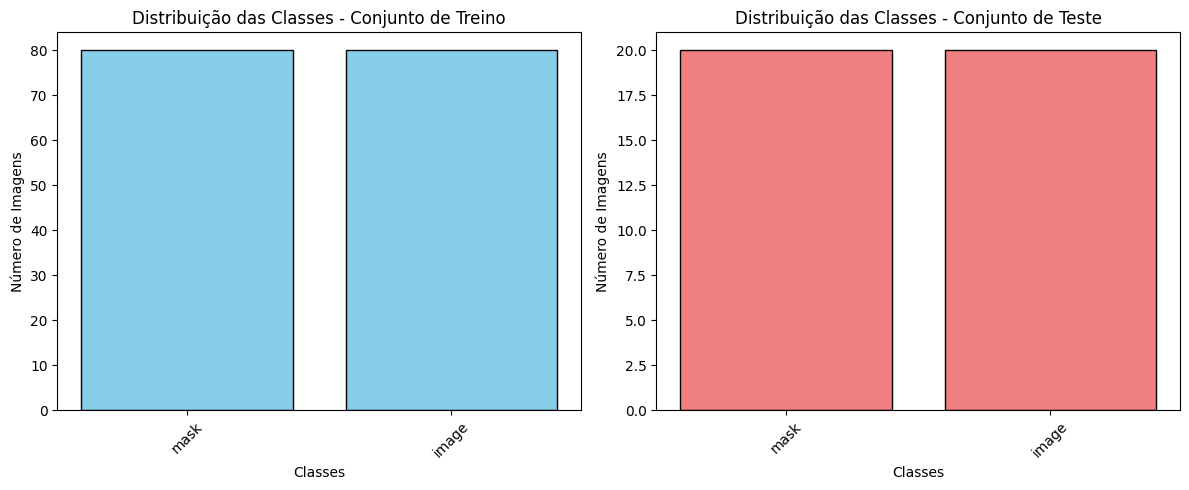

In [ ]:
# Função para contar o número de imagens por classe
def contar_imagens_por_classe(caminho_pasta):

    if not os.path.exists(caminho_pasta):  # Verifica se o diretório existe
        print(f"A pasta '{caminho_pasta}' não foi encontrada.")  # Exibe um aviso caso a pasta não exista
        return {}  # Retorna um dicionário vazio

    # Cria um dicionário onde cada chave é uma classe (nome da pasta) e o valor é a quantidade de imagens
    contagem_por_classe = {
        classe: len(os.listdir(os.path.join(caminho_pasta, classe)))
        for classe in os.listdir(caminho_pasta)
        if os.path.isdir(os.path.join(caminho_pasta, classe))  # Considera apenas diretórios
    }

    return contagem_por_classe  # Retorna o dicionário com as contagens

def plotar_distribuicao_classes(contagem_treino, contagem_teste):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Cria uma figura com 2 gráficos lado a lado

    # Gráfico para o conjunto de treino
    axes[0].bar(contagem_treino.keys(), contagem_treino.values(), color='skyblue', edgecolor='black')  # Cria gráfico de barras
    axes[0].set_title("Distribuição das Classes - Conjunto de Treino")  # Define o título do gráfico
    axes[0].set_xlabel("Classes")  # Nomeia o eixo X
    axes[0].set_ylabel("Número de Imagens")  # Nomeia o eixo Y
    axes[0].tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo X para melhor leitura

    # Gráfico para o conjunto de teste
    axes[1].bar(contagem_teste.keys(), contagem_teste.values(), color='lightcoral', edgecolor='black')  # Cria gráfico de barras
    axes[1].set_title("Distribuição das Classes - Conjunto de Teste")  # Define o título do gráfico
    axes[1].set_xlabel("Classes")  # Nomeia o eixo X
    axes[1].set_ylabel("Número de Imagens")  # Nomeia o eixo Y
    axes[1].tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo X para melhor leitura

    plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos
    plt.show()  # Exibe os gráficos

def main():
    # Contagem das imagens por classe em cada conjunto (treino e teste)
    contagem_treino = contar_imagens_por_classe(pasta_treinamento)
    contagem_teste = contar_imagens_por_classe(pasta_teste)

    if not contagem_treino or not contagem_teste:  # Se não houver imagens em um dos conjuntos
        print("Não foi possível encontrar dados suficientes para análise.")  # Exibe um aviso
        return  # Encerra a execução

    # Exibir contagem das classes no terminal
    print("Distribuição das classes no conjunto de treino:", contagem_treino)
    print("Distribuição das classes no conjunto de teste:", contagem_teste)

    # Gerar os gráficos de distribuição das classes
    plotar_distribuicao_classes(contagem_treino, contagem_teste)


# Garante que o script só será executado se for chamado diretamente (evita execução acidental ao importar como módulo)
if __name__ == "__main__":
    main()

* Conferindo imagens duplicadas que possam enviesar os resultados.
  * Para detectar imagens duplicadas no dataset (mesmo que tenham nomes diferentes), podemos comparar os arquivos pelo hash (assinatura digital) de cada imagem. Isso garante que duas imagens idênticas serão detectadas mesmo que tenham nomes diferentes.

In [ ]:
# Função para calcular o hash de uma imagem
def calcular_hash(imagem_path):
    with Image.open(imagem_path) as img:  # Abre a imagem usando a biblioteca PIL (Pillow)
        img = img.convert("L")  # Converte para escala de cinza para reduzir variações de cor
        return hashlib.md5(img.tobytes()).hexdigest()  # Gera um hash MD5 com os bytes da imagem


# Função para encontrar duplicatas dentro de uma pasta
def encontrar_duplicatas(pasta):
    hashes = defaultdict(list)  # Dicionário onde a chave é o hash e o valor é uma lista de arquivos com o mesmo hash
    for arquivo in os.listdir(pasta):  # Percorre todos os arquivos da pasta
        caminho_completo = os.path.join(pasta, arquivo)  # Obtém o caminho completo do arquivo
        if arquivo.lower().endswith(('.png', '.jpg', '.jpeg')):  # Verifica se é uma imagem
            hash_imagem = calcular_hash(caminho_completo)  # Calcula o hash da imagem
            hashes[hash_imagem].append(caminho_completo)  # Adiciona o arquivo à lista de imagens com esse hash

    # Criar um dicionário para armazenar apenas os hashes que possuem mais de uma imagem associada
    duplicatas = {}

    # Percorre todos os hashes e suas respectivas listas de arquivos
    for hash_valor, arquivos in hashes.items():
        # Se houver mais de um arquivo associado ao mesmo hash, significa que são duplicatas
        if len(arquivos) > 1:
            duplicatas[hash_valor] = arquivos

    return duplicatas  # Retorna um dicionário com os arquivos duplicados


pastas_imagem = [
    os.path.join(path, "Data", "train", "image"),  # Caminho para imagens de treino
    os.path.join(path, "Data", "test", "image")    # Caminho para imagens de teste
]
pastas_mask = [
    os.path.join(path, "Data", "train", "mask"),   # Caminho para máscaras de treino
    os.path.join(path, "Data", "test", "mask")     # Caminho para máscaras de teste
]


# Verificar duplicatas em imagens e máscaras separadamente
display(md("\n🔍 **Duplicatas em imagens:**"))  # Exibe um título formatado
for pasta in pastas_imagem:  # Percorre cada pasta de imagens
    duplicatas = encontrar_duplicatas(pasta)  # Chama a função para verificar duplicatas
    if duplicatas:  # Se encontrou duplicatas
        display(md(f"Duplicatas encontradas em {pasta}:"))
        for h, arquivos in duplicatas.items():  # Percorre os hashes e os arquivos duplicados
            display(md(f"  - Hash: {h}"))  # Exibe o hash da imagem duplicada
            for arq in arquivos:  # Exibe cada arquivo duplicado
                display(md(f"    * {arq}"))
    else:
        display(md(f"Nenhuma duplicata encontrada em {pasta}"))  # Se não houver duplicatas


display(md("\n🔍 **Duplicatas em máscaras:**"))
for pasta in pastas_mask:  # Percorre cada pasta de máscaras
    duplicatas = encontrar_duplicatas(pasta)  # Chama a função para verificar duplicatas
    if duplicatas:  # Se encontrou duplicatas
        display(md(f"Duplicatas encontradas em {pasta}:"))
        for h, arquivos in duplicatas.items():  # Percorre os hashes e os arquivos duplicados
            print(f"  - Hash: {h}")  # Exibe o hash da imagem duplicada
            for arq in arquivos:  # Exibe cada arquivo duplicado
                display(md(f"    * {arq}"))
    else:
        display(md(f"Nenhuma duplicata encontrada em {pasta}"))  # Se não houver duplicatas


🔍 **Duplicatas em imagens:**

Nenhuma duplicata encontrada em /content/drive/MyDrive/dataset_retina/Data/train/image

Nenhuma duplicata encontrada em /content/drive/MyDrive/dataset_retina/Data/test/image


🔍 **Duplicatas em máscaras:**

Nenhuma duplicata encontrada em /content/drive/MyDrive/dataset_retina/Data/train/mask

Nenhuma duplicata encontrada em /content/drive/MyDrive/dataset_retina/Data/test/mask

MELHORAR LEITURA DAS IMAGENS - CONSTRUIR UM DRIVE - GABY (OK, FEITO LÁ EM CIMA)


PROBLEMA DA NORMALIZAÇÃO E REDIMENSIONAMENTO (CORRIGIR PRÉ PROCESSAMENTO - CARREGAMENTO DOS DADOS)  - CATHARINA (USAR O LINK DO DIRETORIO QUE A GABY FEZ NO DRIVE)

Verificando caminho do dataset: /content/drive/MyDrive/dataset_retina
O caminho existe? True
Verificando pasta de treinamento: /content/drive/MyDrive/dataset_retina/Data/train
A pasta de treinamento existe? True
Dataset encontrado em: /content/drive/MyDrive/dataset_retina

Caminhos encontrados:
Imagens de treino: /content/drive/MyDrive/dataset_retina/Data/train/image (Existe: True)
Máscaras de treino: /content/drive/MyDrive/dataset_retina/Data/train/mask (Existe: True)
Imagens de teste: /content/drive/MyDrive/dataset_retina/Data/test/image (Existe: True)
Máscaras de teste: /content/drive/MyDrive/dataset_retina/Data/test/mask (Existe: True)

Carregando dados de treinamento...
Carregando dados de: /content/drive/MyDrive/dataset_retina/Data/train/image e /content/drive/MyDrive/dataset_retina/Data/train/mask
Encontrados 80 imagens e 80 máscaras


100%|██████████| 80/80 [00:01<00:00, 56.58it/s]


Dados de treinamento carregados: (80, 128, 128, 3), (80, 128, 128, 1)
Dataset de treinamento criado com sucesso!

Carregando dados de teste...
Carregando dados de: /content/drive/MyDrive/dataset_retina/Data/test/image e /content/drive/MyDrive/dataset_retina/Data/test/mask
Encontrados 20 imagens e 20 máscaras


100%|██████████| 20/20 [00:00<00:00, 59.75it/s]


Dados de teste carregados: (20, 128, 128, 3), (20, 128, 128, 1)
Dataset de teste criado com sucesso!

Visualizando amostras para verificar o pré-processamento:


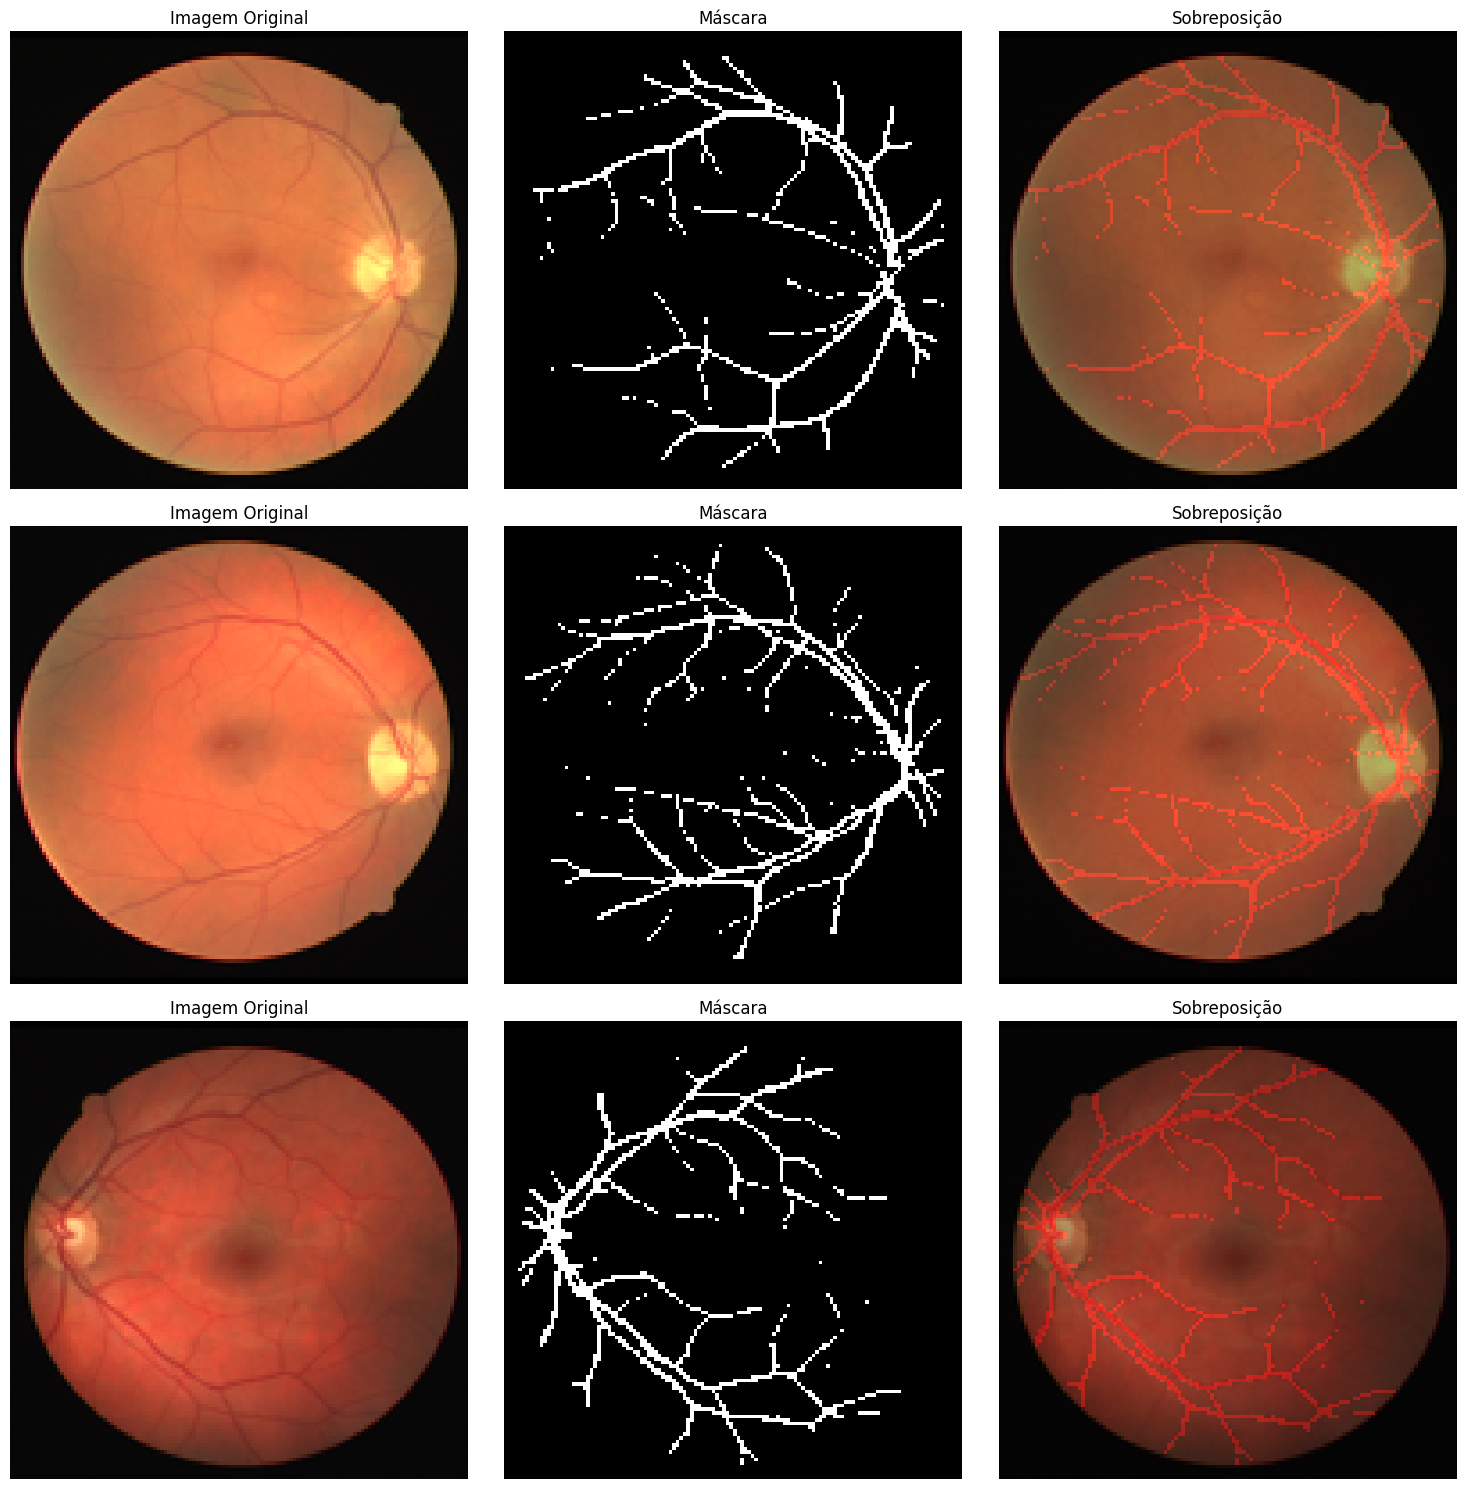

Pré-processamento concluído. Os datasets 'treino_dataset' e 'teste_dataset' estão prontos para uso no modelo.


In [ ]:
pasta_treinamento = os.path.join(path, "Data", "train")
pasta_teste = os.path.join(path, "Data", "test")

# Verificar se os caminhos existem
print(f"Verificando caminho do dataset: {path}")
print(f"O caminho existe? {os.path.exists(path)}")

print(f"Verificando pasta de treinamento: {pasta_treinamento}")
print(f"A pasta de treinamento existe? {os.path.exists(pasta_treinamento)}")

# Função de pré-processamento para carregar e redimensionar as imagens
def carregar_e_preprocessar_dados(pasta_imagem, pasta_mascara, tamanho_alvo=(128, 128)):

    # Verificar se as pastas existem
    if not os.path.exists(pasta_imagem):
        raise FileNotFoundError(f"Pasta de imagens não encontrada: {pasta_imagem}")
    if not os.path.exists(pasta_mascara):
        raise FileNotFoundError(f"Pasta de máscaras não encontrada: {pasta_mascara}")

    print(f"Carregando dados de: {pasta_imagem} e {pasta_mascara}")

    imagens = []
    mascaras = []

    # Listar os arquivos nas pastas
    arquivos_imagem = sorted([f for f in os.listdir(pasta_imagem)
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])
    arquivos_mascara = sorted([f for f in os.listdir(pasta_mascara)
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])

    print(f"Encontrados {len(arquivos_imagem)} imagens e {len(arquivos_mascara)} máscaras")

    # Processar cada par de imagem e máscara
    for arquivo_img, arquivo_mask in tqdm(zip(arquivos_imagem, arquivos_mascara), total=len(arquivos_imagem)):
        # Carregar imagem e redimensionar
        caminho_imagem = os.path.join(pasta_imagem, arquivo_img)
        img = Image.open(caminho_imagem)
        img = img.resize(tamanho_alvo)
        img_array = np.array(img)

        # Carregar máscara e redimensionar
        caminho_mascara = os.path.join(pasta_mascara, arquivo_mask)
        mask = Image.open(caminho_mascara)
        mask = mask.resize(tamanho_alvo)
        mask_array = np.array(mask)

        # Converter máscara para binário (0 ou 1)
        if len(mask_array.shape) == 3 and mask_array.shape[2] > 1:
            # Se a máscara tiver múltiplos canais, converter para escala de cinza
            mask_array = np.mean(mask_array, axis=2)

        # Binarizar a máscara (limiar em 128)
        mask_array = (mask_array > 128).astype(np.float32)

        # Adicionar dimensão de canal se necessário
        if len(mask_array.shape) == 2:
            mask_array = np.expand_dims(mask_array, axis=-1)

        # Normalizar imagem (dividir por 255 para escalar entre 0-1)
        img_array = img_array.astype(np.float32) / 255.0

        # Adicionar aos arrays
        imagens.append(img_array)
        mascaras.append(mask_array)

    return np.array(imagens), np.array(mascaras)

# Criar datasets do TensorFlow para treinamento e teste
def criar_tf_dataset(imagens, mascaras, tamanho_batch=32, shuffle=True):

    dataset = tf.data.Dataset.from_tensor_slices((imagens, mascaras))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(imagens))

    dataset = dataset.batch(tamanho_batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Tente encontrar automaticamente os caminhos corretos
def encontrar_pastas_dataset():
    base_path = '/content/drive/MyDrive'

    # Lugares possíveis para o dataset
    caminhos_possiveis = [
        os.path.join(base_path, 'dataset_retina'),
        os.path.join(base_path, 'Colab Notebooks', 'dataset_retina')
    ]

    # Verificar qual caminho existe
    for caminho in caminhos_possiveis:
        if os.path.exists(caminho):
            print(f"Dataset encontrado em: {caminho}")
            return caminho

    # Se não encontrar, tentar procurar em MyDrive
    print("Procurando pelo dataset em My Drive...")
    for root, dirs, files in os.walk(base_path):
        if 'dataset_retina' in dirs:
            caminho = os.path.join(root, 'dataset_retina')
            print(f"Dataset encontrado em: {caminho}")
            return caminho

    print("Dataset não encontrado!")
    return None

# Encontrar o caminho correto do dataset
path_encontrado = encontrar_pastas_dataset()
if path_encontrado:
    path = path_encontrado
    dataset_path = Path(path)
    pasta_treinamento = os.path.join(path, "Data", "train")
    pasta_teste = os.path.join(path, "Data", "test")

    # Verificar se as subpastas existem
    pasta_img_treino = os.path.join(pasta_treinamento, "image")
    pasta_mask_treino = os.path.join(pasta_treinamento, "mask")
    pasta_img_teste = os.path.join(pasta_teste, "image")
    pasta_mask_teste = os.path.join(pasta_teste, "mask")

    print("\nCaminhos encontrados:")
    print(f"Imagens de treino: {pasta_img_treino} (Existe: {os.path.exists(pasta_img_treino)})")
    print(f"Máscaras de treino: {pasta_mask_treino} (Existe: {os.path.exists(pasta_mask_treino)})")
    print(f"Imagens de teste: {pasta_img_teste} (Existe: {os.path.exists(pasta_img_teste)})")
    print(f"Máscaras de teste: {pasta_mask_teste} (Existe: {os.path.exists(pasta_mask_teste)})")

    # Carregar dados somente se os caminhos existirem
    if os.path.exists(pasta_img_treino) and os.path.exists(pasta_mask_treino):
        print("\nCarregando dados de treinamento...")
        X_treino, y_treino = carregar_e_preprocessar_dados(pasta_img_treino, pasta_mask_treino)
        print(f"Dados de treinamento carregados: {X_treino.shape}, {y_treino.shape}")

        # Criar dataset de treinamento
        treino_dataset = criar_tf_dataset(X_treino, y_treino)
        print("Dataset de treinamento criado com sucesso!")
    else:
        print("Erro: Pastas de imagens ou máscaras de treinamento não encontradas.")

    if os.path.exists(pasta_img_teste) and os.path.exists(pasta_mask_teste):
        print("\nCarregando dados de teste...")
        X_teste, y_teste = carregar_e_preprocessar_dados(pasta_img_teste, pasta_mask_teste)
        print(f"Dados de teste carregados: {X_teste.shape}, {y_teste.shape}")

        # Criar dataset de teste
        teste_dataset = criar_tf_dataset(X_teste, y_teste, shuffle=False)
        print("Dataset de teste criado com sucesso!")
    else:
        print("Erro: Pastas de imagens ou máscaras de teste não encontradas.")

    # Visualizar algumas imagens para verificar
    def visualizar_amostras(dataset, num_amostras=3):
        plt.figure(figsize=(15, 5*num_amostras))

        for i, (imagens, mascaras) in enumerate(dataset.take(num_amostras)):
            imagem = imagens[0].numpy()  # Pegar a primeira imagem do batch
            mascara = mascaras[0].numpy()  # Pegar a primeira máscara do batch

            # Imagem original
            plt.subplot(num_amostras, 3, i*3+1)
            plt.imshow(imagem)
            plt.title('Imagem Original')
            plt.axis('off')

            # Máscara
            plt.subplot(num_amostras, 3, i*3+2)
            plt.imshow(mascara[:,:,0], cmap='gray')
            plt.title('Máscara')
            plt.axis('off')

            # Sobreposição
            plt.subplot(num_amostras, 3, i*3+3)
            sobreposicao = imagem.copy()
            mascara_overlay = np.zeros_like(sobreposicao)
            mascara_overlay[:,:,0] = mascara[:,:,0] * 1.0  # Canal vermelho
            sobreposicao = sobreposicao * 0.7 + mascara_overlay * 0.3
            plt.imshow(sobreposicao)
            plt.title('Sobreposição')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Visualizar alguns exemplos, se o dataset foi criado
    if 'treino_dataset' in locals():
        print("\nVisualizando amostras para verificar o pré-processamento:")
        visualizar_amostras(treino_dataset)

        print("Pré-processamento concluído. Os datasets 'treino_dataset' e 'teste_dataset' estão prontos para uso no modelo.")

else:
    print("Não foi possível encontrar o dataset. Verifique manualmente o caminho correto.")

## TREINAMENTO DO MODELO

Since the dataset is realtivally small lets create our own model withou transfer learning

SUGESTÃO DE MAIS OU MENOS CAMADAS? ADD U-NET MER - ALAN

In [ ]:
# Definindo as funções do modelo U-Net

def unet_model(input_size=(128, 128, 3), num_classes=1):
    """
    Cria um modelo U-Net para segmentação de imagens

    Parâmetros:
    - input_size: Tamanho de entrada das imagens (altura, largura, canais)
    - num_classes: Número de classes para segmentação

    Retorna:
    - Modelo U-Net não compilado
    """
    # Função para criar um bloco de convolução
    def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
        x = layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
        x = layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
        return x

    # Caminho de Contração (Encoder)
    inputs = layers.Input(input_size)

    # Encoder Path
    conv1 = conv_block(inputs, 64)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 512)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bridge
    conv5 = conv_block(pool4, 1024)

    # Caminho de Expansão (Decoder)

    # Upsample + Skip connection do conv4
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat6 = layers.Concatenate()([up6, conv4])
    conv6 = conv_block(concat6, 512)

    # Upsample + Skip connection do conv3
    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = layers.Concatenate()([up7, conv3])
    conv7 = conv_block(concat7, 256)

    # Upsample + Skip connection do conv2
    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat8 = layers.Concatenate()([up8, conv2])
    conv8 = conv_block(concat8, 128)

    # Upsample + Skip connection do conv1
    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat9 = layers.Concatenate()([up9, conv1])
    conv9 = conv_block(concat9, 64)

    # Camada de saída
    if num_classes == 1:  # Segmentação binária
        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    else:  # Segmentação multiclasse
        outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    # Criar o modelo
    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

def compile_unet(model, learning_rate=1e-4):
    """
    Compila o modelo U-Net

    Parâmetros:
    - model: Modelo a ser compilado
    - learning_rate: Taxa de aprendizado para o otimizador

    Retorna:
    - Modelo compilado
    """
    # Definir otimizador
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Definir loss (função de perda)
    # Para segmentação binária: binary crossentropy
    # Para segmentação multiclasse: sparse categorical crossentropy
    loss = tf.keras.losses.BinaryCrossentropy() if model.output_shape[-1] == 1 else \
           tf.keras.losses.SparseCategoricalCrossentropy()

    # Métricas
    metrics = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1]),  # IoU para a classe 1 (objeto)
    ]

    # Compilar modelo
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

def get_callbacks(model_name="unet_model", patience=10):
    """
    Retorna callbacks úteis para treinar o modelo

    Parâmetros:
    - model_name: Nome base para os arquivos de checkpoint
    - patience: Número de épocas para esperar antes de parar o treinamento se não houver melhoria

    Retorna:
    - Lista de callbacks
    """
    # Checkpoint para salvar o melhor modelo
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"{model_name}_best.h5",
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="min"
    )

    # Early stopping para parar o treinamento quando não houver mais melhoria
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        verbose=1,
        restore_best_weights=True
    )

    # Redutor da taxa de aprendizado
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=patience//2,
        verbose=1,
        mode="min"
    )

    # TensorBoard para visualização do treinamento (opcional)
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=f"./logs/{model_name}_{int(time.time())}",
        histogram_freq=1
    )

    return [checkpoint, early_stopping, lr_reducer, tensorboard]

In [ ]:
from tensorflow.keras import layers, models

# Definindo parâmetros do modelo
img_height = 128
img_width = 128
img_channels = 3  # RGB
num_classes = 1   # Segmentação binária

# Criando o modelo
model = unet_model(input_size=(img_height, img_width, img_channels), num_classes=num_classes)

# Compilando o modelo
model = compile_unet(model, learning_rate=1e-4)

# Exibindo o resumo do modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

WOW 279k+ prams lets continue

lets compile the model with binary_crossentropy as the loss, Adam as optimizer and Accuracy and recall as metrics


SUGESTÃO NOVAS MÉTRICAS (PLOTAR MATRIZ CONFUSÃO) - ANDERSON

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import numpy as np
from PIL import Image

# Configurar diretórios de dados
img_dir = "/content/drive/MyDrive/dataset_retina/Data/train/image"
mask_dir = "/content/drive/MyDrive/dataset_retina/Data/train/mask"
val_img_dir = "/content/drive/MyDrive/dataset_retina/Data/test/image"
val_mask_dir = "/content/drive/MyDrive/dataset_retina/Data/test/mask"

# Classe personalizada para carregar imagens e máscaras
class DataGenerator(Sequence):
    def __init__(self, img_dir, mask_dir, batch_size, target_size=(128, 128)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.img_filenames = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        assert len(self.img_filenames) == len(self.mask_filenames), "Número de imagens e máscaras não coincide."

    def __len__(self):
        # Número total de lotes
        return int(np.ceil(len(self.img_filenames) / self.batch_size))

    def __getitem__(self, index):
        # Obter um lote de dados
        img_batch = self.img_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        mask_batch = self.mask_filenames[index * self.batch_size:(index + 1) * self.batch_size]

        imgs, masks = [], []
        for img_file, mask_file in zip(img_batch, mask_batch):
            img_path = os.path.join(self.img_dir, img_file)
            mask_path = os.path.join(self.mask_dir, mask_file)

            # Carregar e redimensionar imagens e máscaras
            img = Image.open(img_path).convert("RGB").resize(self.target_size)
            mask = Image.open(mask_path).convert("L").resize(self.target_size)

            imgs.append(np.array(img) / 255.0)  # Normalizar imagens
            masks.append(np.expand_dims(np.array(mask) / 255.0, axis=-1))  # Normalizar e adicionar dimensão de canal

        return np.array(imgs), np.array(masks)

# Criar geradores de dados
batch_size = 16
train_generator = DataGenerator(img_dir, mask_dir, batch_size)
val_generator = DataGenerator(val_img_dir, val_mask_dir, batch_size)
callbacks = get_callbacks(model_name='unet_retina')





GRÁFICOS DE LOSS COMENTAR OVERFITING -HANNA

lets get some callbacks

In [ ]:
# Treinar o modelo
history = model.fit(
    train_generator,
    callbacks=callbacks,
    epochs=50
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - binary_accuracy: 0.6947 - io_u: 0.0000e+00 - loss: 0.6795

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: binary_accuracy,io_u,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: binary_accuracy,io_u,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - binary_accuracy: 0.6975 - io_u: 0.0000e+00 - loss: 0.6786 - learning_rate: 1.0000e-04
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - binary_accuracy: 0.7292 - io_u: 0.0000e+00 - loss: 0.6453 - learning_rate: 1.0000e-04
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - binary_accuracy: 0.7272 - io_u: 0.0000e+00 - loss: 0.5932 - learning_rate: 1.0000e-04
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - binary_accuracy: 0.7336 - io_u: 0.0000e+00 - loss: 0.4742 - learning_rate: 1.0000e-04
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - binary_accuracy: 0.7286 - io_u: 0.0000e+00 - loss: 0.4261 - learning_rate: 1.0000e-04
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - binary_accuracy: 0.7329 - io_u: 0.0000e+00 - loss: 0.4262 - learning_rate: 1.0000e-04
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - binary_accuracy: 0.7343 - io_u: 0.0000e+00 - loss: 0.4032 - learning_rate: 1.0000e-04
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - binary_accuracy